In [395]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
import os
import torch
import importlib

In [396]:
sys.path.append('../src/porbnet')
import networks_porbnet
import util_porbnet
np.random.seed(0)
torch.manual_seed(0)

In [397]:
importlib.reload(networks_porbnet)
importlib.reload(util_porbnet)

<module 'util_porbnet' from '../src/porbnet/util_porbnet.py'>

In [398]:
def plot_stationarity(x,f,h,ax=None):

    # Distances between points
    dx = x[1:] - x[:-1]
    if dx.max() - dx.min() > 1e2 or np.any(dx<0):
        print('x needs to be increasing and evenly spaced')
        return
    dx = np.cumsum(np.concatenate([np.array([0]),dx]))
    h_idx = np.argmin(np.abs(dx - h[:,np.newaxis]),axis=1) #Closest multiple of dx to h
    
    # Covariances at offset h
    C = np.cov(f.T)
    Ch = [np.diagonal(C,offset=h) for h in h_idx]

    pad = [(int(np.floor((x.size-row.size)/2)),int(np.ceil((x.size-row.size)/2))) for row in Ch]
    Ch_mat = np.array([\
        np.concatenate([np.full(p[0],np.nan), row,np.full(p[1],np.nan)]) \
        for (p,row) in zip(pad,Ch)])

    # Figure
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, Ch_mat.T,'o-',alpha=.025)
    ax.legend(['t=%.1f' % h for h in dx[h_idx]], loc='upper right')

    ax.set_xlabel(r'$x$')
    
    return ax

## Fixed uniform intensity

In [399]:
intensity = 10
s2_0 = 4
T = [-1,1]
prior_b_sig2 = 1e-16
prior_w_sig2 = 1.0

x_plot = np.linspace(-1.5,1.5,1000)

In [400]:
intensity_func = util_porbnet.Piecewise(np.array([T[0],T[1]]),np.array([intensity])) 

dim_hidden_initial = (T[1]-T[0])*intensity

net = networks_porbnet.RBFN(dim_in=1, dim_hidden_initial=dim_hidden_initial, \
                            dim_hidden_max=3*dim_hidden_initial, \
                            dim_out=1, intensity=intensity_func, s2_0=s2_0, \
                            prior_w_sig2 = prior_w_sig2*np.sqrt(np.pi/s2_0), prior_b_sig2 = prior_b_sig2, \
                            sig2 = .01,\
                            prior_intensity_alpha = intensity, prior_intensity_beta = 1.0)

torch.manual_seed(0)
f_samp = net.sample_functions_prior(torch.from_numpy(x_plot).reshape(-1,1), n_samp=1000, sample_K=True, sample_intensity=False).detach().numpy()



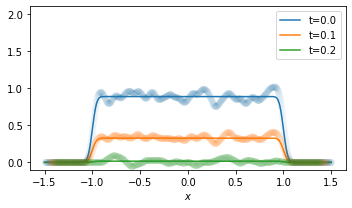

In [401]:
h_list = np.array([0,.1,.2])
fig, ax = plt.subplots(figsize=(5,3))
colors = ['C0','C1','C2']

for i, h in enumerate(h_list): 
    cov_plot = util_porbnet.cov_porbnet_fixed_intensity(x1=x_plot-h/2, \
                                             x2=x_plot+h/2, \
                                             C0=T[0], \
                                             C1=T[1], \
                                             b_sig2=prior_b_sig2, \
                                             w_sig2=prior_w_sig2, \
                                             s2_0=s2_0, \
                                             intensity=intensity)
    ax.plot(x_plot, cov_plot, color=colors[i])
    
plot_stationarity(x_plot,f_samp,h=h_list,ax=ax)
ax.set_ylim(-.1,2.1)
fig.tight_layout()

In [402]:
fig.savefig('covariogram_porbnet.pdf')
fig.savefig('covariogram_porbnet.png')

## Uniform intensity with Gamma prior

In [403]:
intensity = 10
s2_0 = 1
T = [-1,1]
prior_b_sig2 = 1e-16
prior_w_sig2 = 1.0

x_plot = np.linspace(-1.5,1.5,1000)

In [404]:
alpha = util_porbnet.alpha_for_sqrt_gamma(beta=1.0, K=intensity)

In [405]:
intensity_func = util_porbnet.Piecewise(np.array([T[0],T[1]]),np.array([intensity])) 

dim_hidden_initial = (T[1]-T[0])*intensity

net = networks_porbnet.RBFN(dim_in=1, dim_hidden_initial=dim_hidden_initial, \
                            dim_hidden_max=3*dim_hidden_initial, \
                            dim_out=1, intensity=intensity_func, s2_0=s2_0, \
                            prior_w_sig2 = prior_w_sig2*np.sqrt(np.pi/s2_0), prior_b_sig2 = prior_b_sig2, \
                            sig2 = .01,\
                            prior_intensity_alpha = alpha, prior_intensity_beta = 1.0)

torch.manual_seed(0)
f_samp = net.sample_functions_prior(torch.from_numpy(x_plot).reshape(-1,1), n_samp=1000, sample_K=True, sample_intensity=True).detach().numpy()



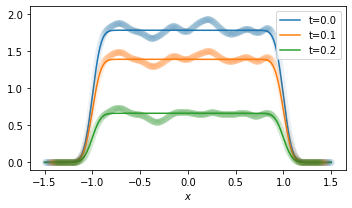

In [406]:
h_list = np.array([0, .1, .2])
fig, ax = plt.subplots(figsize=(5,3))
colors = ['C0','C1','C2']

for i, h in enumerate(h_list): 
    cov_plot = util_porbnet.cov_porbnet_gamma_intensity(x1=x_plot-h/2,\
                                           x2=x_plot+h/2,\
                                           C0=T[0],\
                                           C1=T[1],\
                                           b_sig2=prior_b_sig2,\
                                           w_sig2=prior_w_sig2,\
                                           s2_0=s2_0,\
                                           intensity_alpha=alpha,\
                                           intensity_beta=1.0)
    ax.plot(x_plot, cov_plot, color=colors[i])
    
plot_stationarity(x_plot,f_samp,h=h_list,ax=ax)
ax.set_ylim(-.1,2.1)
fig.tight_layout()

In [407]:
fig.savefig('covariogram_porbnet_sgcp.pdf')
fig.savefig('covariogram_porbnet_sgcp.png')